In [3]:
import sys
sys.path.insert(1, r'C:\Users\Donald\PycharmProjects\monkey_nuc_segment\stardist\monkey')
from scoring_for_donald import TileSetScorer, ScoringSubroutine

In [4]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
import json
matplotlib.rcParams["image.interpolation"] = 'nearest'
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from glob import glob
from tqdm import tqdm
from tifffile import imread
import struct
import pandas as pd
import cv2
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D

In [5]:
def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model

In [11]:
model_pths = r'\\10.99.68.178\andreex\data\Stardist\models'
pths = os.listdir(model_pths)
pths = ["".join([model_pths, '\\', pth]) for pth in pths if 'monkey' in pth]
print(pths)

['\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_fallopian_tube_AF__11_03_2023_1e-4', '\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.0001_epochs_200_pt_10', '\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.0001_epochs_200_pt_20', '\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.0001_epochs_200_pt_30', '\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.0001_epochs_200_pt_40', '\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.0001_epochs_300_pt_10', '\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.0001_epochs_300_pt_20', '\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.0001_epochs_300_pt_30', '\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.0001_epochs_300_pt_40', '\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.0001_epoc

In [12]:
models = [load_model(pth) for pth in pths]

base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.178\andreex\data\Stardist\models\monkey_fallopian_tube_AF__11_03_2023_1e-4\offshoot_model


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.63499129199699, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.6234272415078469, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.6177822926111398, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.6583108100983135, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.5969906755887175, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.6091601755700365, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.6392385662308695, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.6503999390135518, nms=0.3) 

Using default valu

base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.178\andreex\data\Stardist\models\monkey_ft_11_03_2023_lr_0.001_epochs_400_pt_40\offshoot_model


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.5742374622613553, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.14602531157276818, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.14240266496575799, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.1423563290796493, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.14036238223520514, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.14104847178904759, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.14189460664342962, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.14565859023425276, nms=0.3) 

Using defa

In [13]:
# load tile images and masks
pthHE = r'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\tiles'
pthmasks = r'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\qupath\ground_truth\masks'

HE_tiles_pths = sorted(glob(os.path.join(pthHE,'*.tif')))
mask_tiles_pths = sorted(glob(os.path.join(pthmasks,'*.tif')))

HE_tiles = list(map(imread,HE_tiles_pths))
mask_tiles = list(map(imread,mask_tiles_pths))

HE_tiles_default = [normalize(x) for x in HE_tiles]  # just divide by 255 to get into (0,1) range
mask_tiles_default = [fill_label_holes(y) for y in mask_tiles]  # fills holes in annotations if there are any

HE_tiles = [x/255 for x in HE_tiles]  # just divide by 255 to get into (0,1) range
mask_tiles = [fill_label_holes(y) for y in mask_tiles]  # fills holes in annotations if there are any

In [14]:
def get_predictions(model):
    mask_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(HE_tiles)]

    return mask_val_pred

In [16]:
# variables for plotting and stuff
nms = [os.path.basename(file) for file in HE_tiles_pths]

taus = [0.6]

predictions = [get_predictions(model) for model in models]

scores = [TileSetScorer(nms, mask_tiles, mask_val_pred, taus) for mask_val_pred in predictions]

100%|██████████| 36/36 [00:01<00:00, 18.15it/s]
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The

In [17]:
results = [score.score_set() for score in scores]

scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty 

In [19]:
def find_first_unique_indices(lst):
    unique_indices = {}
    result = []

    for i, value in enumerate(lst):
        if value not in unique_indices:
            unique_indices[value] = i

    for value in lst:
        result.append(unique_indices[value])

    return result

In [20]:
def get_f1(tp, fp, fn):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    avg_precision = tp / (tp + fp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, avg_precision, f1

In [29]:
def get_organ_f1(result):
    names = result['Image']

    names = [name.split(".")[0][21:] for name in names]

    for i in range(len(names)):
        #if len(names[i]) > 6:
        names[i] = names[i][:2]

    result_list = find_first_unique_indices(names)

    f1_scores = result['F1 Score']

    seen = []
    names = []

    raw_vals = result[['Image', 'TP', 'FP', 'FN']]

    TPs = [0 for _ in range(len(raw_vals))]
    FPs = [0 for _ in range(len(raw_vals))]
    FNs = [0 for _ in range(len(raw_vals))]

    for i in range(len(raw_vals)):
        row = raw_vals.iloc[i]
        num = result_list[i]
        if num not in seen:
            names.append(raw_vals['Image'][i])
            seen.append(num)

        TPs[num] += row['TP']
        FPs[num] += row['FP']
        FNs[num] += row['FN']

    organ_names = []
    for i in range(len(names)):
        nm = names[i][21:-4]
        if nm[-1] == '1':
            nm = nm[:-1]
        organ_names.append(nm)

    TPs = [val for val in TPs if val != 0]
    FPs = [val for val in FPs if val != 0]
    FNs = [val for val in FNs if val != 0]

    if [len(organ_names), len(TPs), len(FPs), len(FNs)] != [len(organ_names), len(organ_names), len(organ_names), len(organ_names)]:
        print('skipped')
        return 0

    new_df = pd.DataFrame({'Organ': organ_names, 'TP': TPs, 'FP': FPs, 'FN': FNs})

    precisions = []
    recalls = []
    f1s = []

    for i in range(len(new_df)):
        row = new_df.iloc[i]

        tp = row['TP']
        fp = row['FP']
        fn = row['FN']

        precision, recall, avg_precision, f1 = get_f1(tp, fp, fn)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    new_df['Recall'] = recalls
    new_df['Precision'] = precisions
    new_df['F1'] = f1s

    return new_df

In [30]:
dfs = [get_organ_f1(result) for result in results]

skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped


In [56]:
bad_models = []
bad_model_inds = []
for i, j in enumerate(dfs):
    if type(j) != pd.DataFrame:
        bad_models.append(pths[i])
        bad_model_inds.append(i)
        print(i)

25
26
27
28
29
30
31
32
33
34
36


In [42]:
bad_models

['\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.01_epochs_200_pt_10',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.01_epochs_200_pt_20',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.01_epochs_200_pt_30',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.01_epochs_200_pt_40',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.01_epochs_300_pt_10',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.01_epochs_300_pt_20',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.01_epochs_300_pt_30',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.01_epochs_300_pt_40',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.01_epochs_400_pt_10',
 '\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.01_epochs_40

In [57]:
bad_model_inds

[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36]

In [62]:
best_min = 0
best_ind = 0
for i, df in enumerate(dfs):
    if i not in bad_model_inds:
        min_f1 = min(df['F1'])
        if best_min < min_f1:
            best_min = min_f1
            best_ind = i

In [63]:
best_min

0.5877422734415925

In [64]:
best_ind

22

In [65]:
pths[22]

'\\\\10.99.68.178\\andreex\\data\\Stardist\\models\\monkey_ft_11_03_2023_lr_0.001_epochs_400_pt_20'

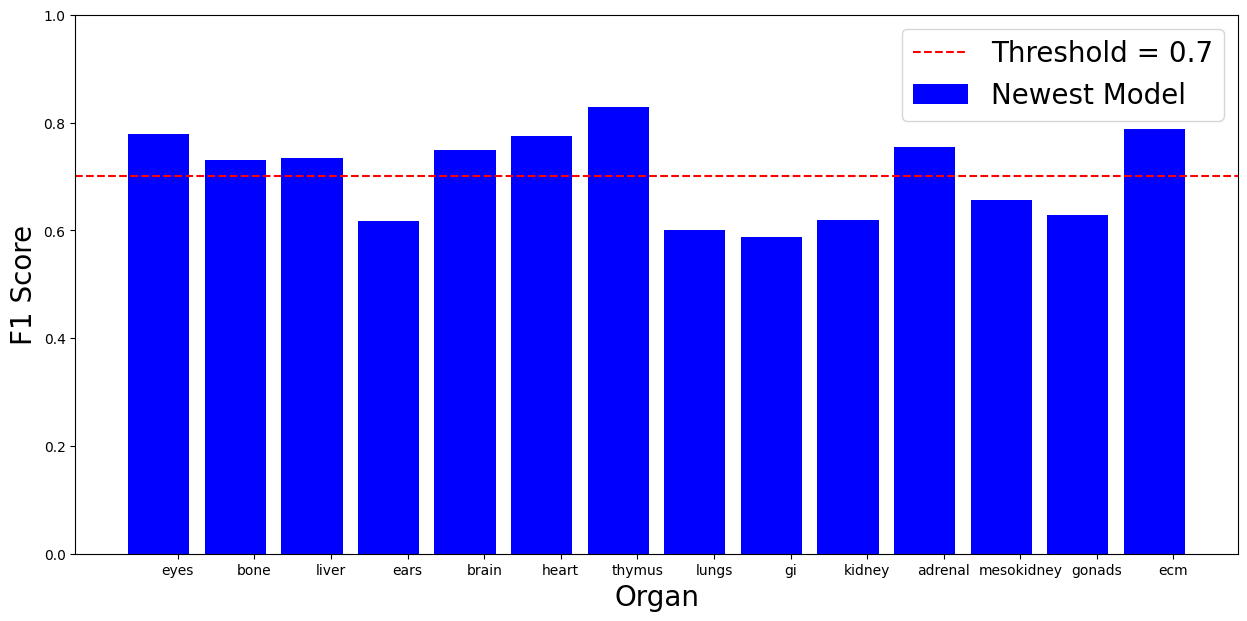

In [67]:
new_df = dfs[22]

bar_width = 0.25  # Adjust the width of each bar as needed
index = np.arange(len(new_df['Organ']))

# Plotting the bars
fig = plt.figure(figsize=(15, 7))
fig.set_facecolor('white')

plt.bar(new_df['Organ'], new_df['F1'], color='blue', label='Newest Model')

#plt.bar(index, f1_scores, color='blue', width=bar_width, label='Newest Model')
#plt.bar(index + bar_width, f1_scores_justin, color='orange', width=bar_width, label="Previous model")
#plt.bar(index + 2 * bar_width, f1_scores_default, color='green', width=bar_width, label='Default H&E')

plt.xlabel("Organ", fontsize=20)
plt.ylabel("F1 Score", fontsize=20)
# plt.title("F1 Scores in Testing Tiles (tau = 0.6)", fontsize=28)
plt.axhline(y=0.7, linestyle='--', color='red', label='Threshold = 0.7')
plt.ylim(0, 1)
plt.xticks(index + bar_width, new_df['Organ'])  # Set x-axis labels to tile names
plt.legend(fontsize=20)
plt.show()